---
Metody numeryczne dla stochastycznych równań różniczkowych
---
Projekt Agnieszka Żaba

In [1]:
!nvidia-smi

Wed Jun 29 17:42:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 511.65       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:82:00.0 Off |                  N/A |
|  0%   50C    P8     9W / 151W |   1010MiB /  8192MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
#NUMBA_CUDA_DRIVER="/usr/lib/wsl/lib/libcuda.so.1" python -c "from numba import cuda; cuda.detect()"

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from numba import vectorize
from math import sqrt, exp
from tabulate import tabulate

In [4]:
from numba.cuda.random import create_xoroshiro128p_states

In [5]:
from mpl_toolkits.mplot3d import Axes3D

In [6]:
device = cuda.get_current_device()
getattr(device, 'MULTIPROCESSOR_COUNT')

15

In [7]:
blocks = 60
threads_per_block = 256
rng_states = cuda.random.create_xoroshiro128p_states(threads_per_block * blocks, seed=1)

---
Proces Wienera zaimplementowany na CUDA.
---

In [8]:
@cuda.jit
def Wiener(states, N, n, T, out):
  '''
  Funkcja generuje trajektorie procesu Wienera i zapisuje do macierzy out.

  Argumenty:
  states: stany wykorzystywane do generwania liczb pseudoloswych (cuda.random)
  N: int - liczba trajektorii
  n: int - gęstośc siatki
  T: float - horyzont czasowy
  out: matrix (n, N) - macierz, do której zapisywane są wyniki
  '''

  idx = cuda.grid(1)
  stride = cuda.gridsize(1)

  h = T/N
  for i in range(idx, N, stride):
    Wt = 0
    out[0][i] = Wt
    for j in range(1, n):
      dW = cuda.random.xoroshiro128p_normal_float32(states, idx)*sqrt(h)
      Wt += dW
      out[j][i] = Wt

In [9]:
trajectories_num = 100000
grid_density = 1000
T = 1.0
wiener_array = cuda.device_array(shape=(grid_density, trajectories_num))
Wiener[blocks, threads_per_block](rng_states, trajectories_num, grid_density, T, wiener_array); cuda.synchronize()
wiener_result = wiener_array.copy_to_host()

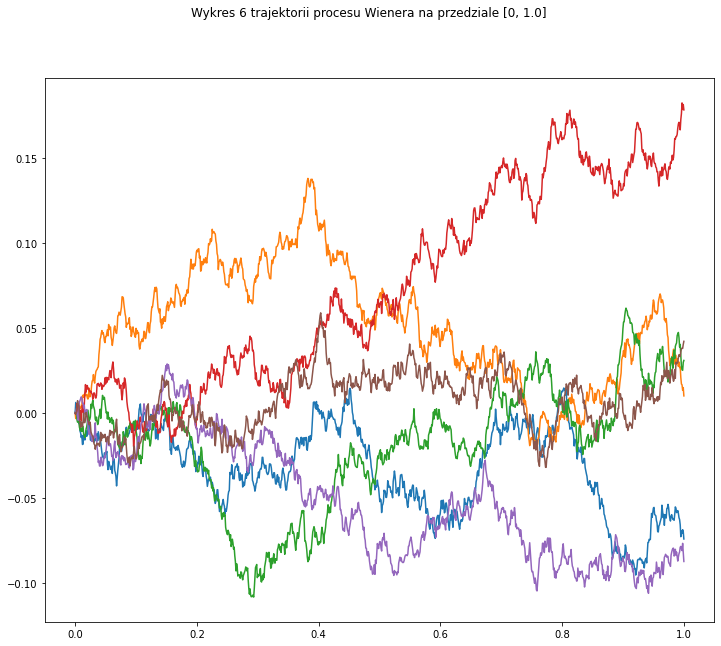

In [10]:
fig, ax = plt.subplots(figsize = (12, 10))
t = np.linspace(0, T, grid_density)
n = 6
fig.suptitle(f'Wykres {n} trajektorii procesu Wienera na przedziale [0, {T}]')
for j in range(n):
  i = int(np.random.random()*trajectories_num)
  plt.plot(t, wiener_result[:, i])

---
Zdefiniowanie ukadu stochastycznych równań różniczkowych
---
\begin{equation}
\begin{split}
dV_1 &= \left(-\frac1{T_1} V_1 - \beta (V_1 - V_2)\right)dt + \sigma_1 dW_1\\
dV_2 &= \left(-\frac1{T_2} V_1 - \beta (V_1 - V_2)\right)dt + \sigma_2 dW_2 
\end{split}
\end{equation}
$V_1$ i $V_2$ są trójwymiarowe i określają turbulentną dyfuzję w 3 wymiarach. Stąd $W_1$ i $W_2$ są trójwymiarowymi niezależnymi procesami Wienera.

In [8]:
T1 = 1
T2 = 0.001
beta = 0.01
sigma1 = 1.0
sigma2 = 1.0

@cuda.jit(device=True)
def a(v1, v2):
  a1 = -1/T1 * v1 - beta * (v1 - v2)
  a2 = -1/T2 * v1 - beta * (v1 - v2)
  return a1, a2

@cuda.jit(device=True)
def b(v1, v2):
  return sigma1, sigma2

In [38]:
@cuda.jit
def Euler(states, N_r, N_g, tr_num, T, V0, out_g, out_r):
  '''
  Funkcja generuje trajektorie dla zadanego ukadu równań korzystając ze shcematu 
  Eulera-Maryuamy. 

  Argumenty:
  states
  N_r:    int         - gestosc siatki rzadkiej
  N_g:    int         - ilośc punktów dogęszczenia, siatka gęsta ma N_r*N_g punktów
  sN_g:   float       - pierwiastek z N_g
  tr_num: int         - liczba trajektorii
  V0:     float (6,)  - wektor wartości V1 i V2 w czasie t=0
  
  out_g:  float32 (6, N_r, tr_num)  - macierz wyniku dla siatki gęstej, ale tylko w punktach siatki rzadkiej
  out_r:  float32 (6, N_r, tr_num)  - macierz wyniku dla siatki rzadkiej
  '''
  idx = cuda.grid(1)
  stride = cuda.gridsize(1)


  h_g = T/N_g/N_r #długość kroku na gęstej siatce
  h_r = T/N_r       #długość kroku na rzadkiej siatce
  sh_g = sqrt(h_g)  
  sh_r = sqrt(h_r)
  sN_g = sqrt(float(N_g-1))
  for i in range(idx, tr_num, stride):
    V1x, V1y, V1z, V2x, V2y, V2z = V0             #punkty początkowe na gęstej siatce
    V1x_r, V1y_r, V1z_r, V2x_r, V2y_r, V2z_r = V0 #punkty początkowe na rzadkiej siatce

    #przepisanie wartości początkowych do macierzy wynikowych
    out_r[0, 0, i] = V1x_r
    out_r[1, 0, i] = V1y_r
    out_r[2, 0, i] = V1z_r
    out_r[3, 0, i] = V2x_r
    out_r[4, 0, i] = V2y_r
    out_r[5, 0, i] = V2z_r

    out_g[0, 0, i] = V1x
    out_g[1, 0, i] = V1y
    out_g[2, 0, i] = V1z
    out_g[3, 0, i] = V2x
    out_g[4, 0, i] = V2y
    out_g[5, 0, i] = V2z

    #pętla po punktach siatki rzadkiej
    for j_r in range(1,N_r+1):
      dW1x_r = 0.0
      dW1y_r = 0.0
      dW1z_r = 0.0
      dW2x_r = 0.0
      dW2y_r = 0.0
      dW2z_r = 0.0

      #pętla po punktach siatki gęstej
      for j_g in range(0, N_g+1):
        #przyrosty z rozkładu N(0,1)
        dW1x_g = cuda.random.xoroshiro128p_normal_float32(states, idx) 
        dW1y_g = cuda.random.xoroshiro128p_normal_float32(states, idx) 
        dW1z_g = cuda.random.xoroshiro128p_normal_float32(states, idx) 
        dW2x_g = cuda.random.xoroshiro128p_normal_float32(states, idx) 
        dW2y_g = cuda.random.xoroshiro128p_normal_float32(states, idx) 
        dW2z_g = cuda.random.xoroshiro128p_normal_float32(states, idx) 

        #zwiększenie przyrostów siatki rzadkiej o aktualny przyrost na siatce gęstej
        dW1x_r += dW1x_g
        dW1y_r += dW1y_g
        dW1z_r += dW1z_g
        dW2x_r += dW2x_g
        dW2y_r += dW2y_g
        dW2z_r += dW2z_g

        #wyliczenie wartości funkcji a i b
        a_V1x, a_V2x = a(V1x, V2x)
        a_V1y, a_V2y = a(V1y, V2y)
        a_V1z, a_V2z = a(V1z, V2z)    
        b_1, b_2 = b(V1x, V2x)

        #wyliczenie wartości modelu w kolejnym kroku
        V1x += a_V1x * h_g + b_1 * dW1x_g* sh_g
        V1y += a_V1y * h_g + b_1 * dW1y_g* sh_g
        V1z += a_V1z * h_g + b_1 * dW1z_g* sh_g
        V2x += a_V2x * h_g + b_2 * dW2x_g* sh_g
        V2y += a_V2y * h_g + b_2 * dW2y_g* sh_g
        V2z += a_V2z * h_g + b_2 * dW2z_g* sh_g

      #zapisanie do macierzy wynikowej
      out_g[0, j_r, i] =  V1x
      out_g[1, j_r, i] =  V1y
      out_g[2, j_r, i] =  V1z
      out_g[3, j_r, i] =  V2x
      out_g[4, j_r, i] =  V2y
      out_g[5, j_r, i] =  V2z

      #wyliczenie wartości a i b dla siatki rzadkiej
      a_V1x, a_V2x = a(V1x_r, V2x_r)
      a_V1y, a_V2y = a(V1y_r, V2y_r)
      a_V1z, a_V2z = a(V1z_r, V2z_r)
      b_1, b_2 = b(V1x_r, V2x_r)
      
      #wyliczenie wartości modelu w kolejnym kroku siatki rzadkiej
      V1x_r += a_V1x * h_r + b_1 * dW1x_r*sh_r/sN_g
      V1y_r += a_V1y * h_r + b_1 * dW1y_r*sh_r/sN_g
      V1z_r += a_V1z * h_r + b_1 * dW1z_r*sh_r/sN_g
      V2x_r += a_V2x * h_r + b_2 * dW2x_r*sh_r/sN_g
      V2y_r += a_V2y * h_r + b_2 * dW2y_r*sh_r/sN_g
      V2z_r += a_V2z * h_r + b_2 * dW2z_r*sh_r/sN_g

      #zapisanie do macierzy wynikowej
      out_r[0, j_r, i] = V1x_r
      out_r[1, j_r, i] = V1y_r
      out_r[2, j_r, i] = V1z_r
      out_r[3, j_r, i] = V2x_r
      out_r[4, j_r, i] = V2y_r
      out_r[5, j_r, i] = V2z_r
      

In [44]:
trajectories_num = 1000
grid_density = 1000

T = 1.0
v0 = cuda.to_device(np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1]))

euler_g = cuda.device_array(shape=(6, grid_density, trajectories_num), dtype=np.float32)
euler_r = cuda.device_array(shape=(6, grid_density, trajectories_num), dtype=np.float32)

Euler[blocks, threads_per_block](rng_states, grid_density, grid_density*10, trajectories_num, T, v0,  euler_g, euler_r)

euler_result_g = euler_g.copy_to_host()
euler_result_r = euler_r.copy_to_host()

In [45]:
def euler_wykres_V(nr=-1):
  if nr==-1:
    nr = int(np.random.uniform(low=0.0, high=trajectories_num))
  for V in [1,2]:
    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(f"Porównanie trajektorii nr {nr} dla V{V} \n wygenerowanej na gęstej i rzadkiej siatce schematem Eulera-Maruyamy", fontsize=16)
    Axes3D.plot(ax, xs = euler_result_g[3*V-3, :, nr], ys = euler_result_g[3*V-2, :, nr], zs = euler_result_g[3*V-1,:,nr] , c = 'r', alpha = 0.4, label = 'siatka gęsta')
    Axes3D.scatter(ax, xs = euler_result_r[3*V-3, :, nr], ys = euler_result_r[3*V-2, :, nr], zs = euler_result_r[3*V-1,:,nr], c = 'b', alpha = 0.8, s=6, label='siatka rzadka')
    ax.legend();

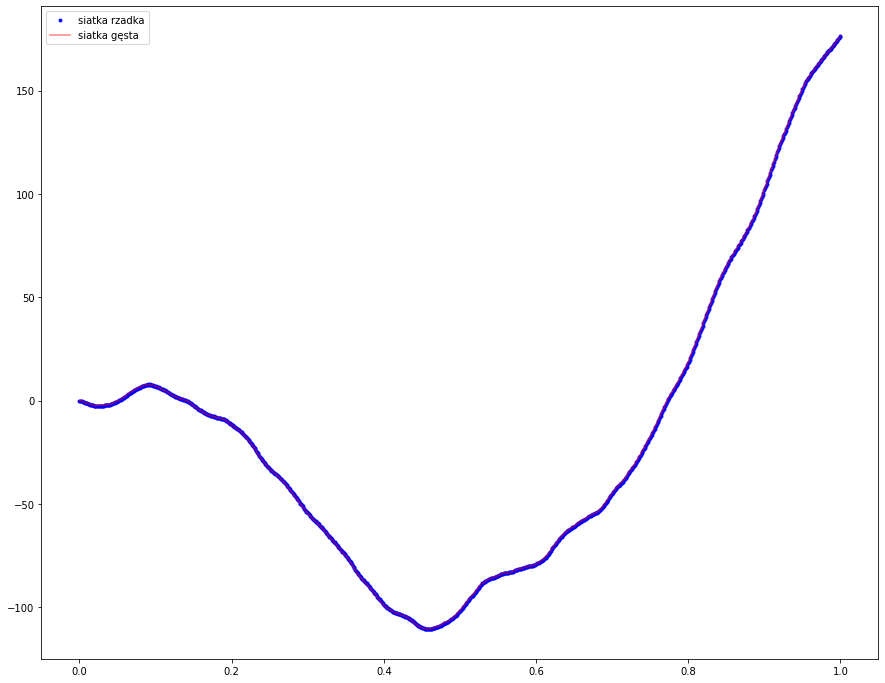

In [46]:
nr = 3
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot()
t = np.linspace(0, T, grid_density)
plt.plot(t, euler_result_r[3, :, nr], 'b.', alpha =0.9,  label = 'siatka rzadka')
plt.plot(t, euler_result_g[3, :, nr], 'r', alpha = 0.5, label = 'siatka gęsta')
ax.legend();

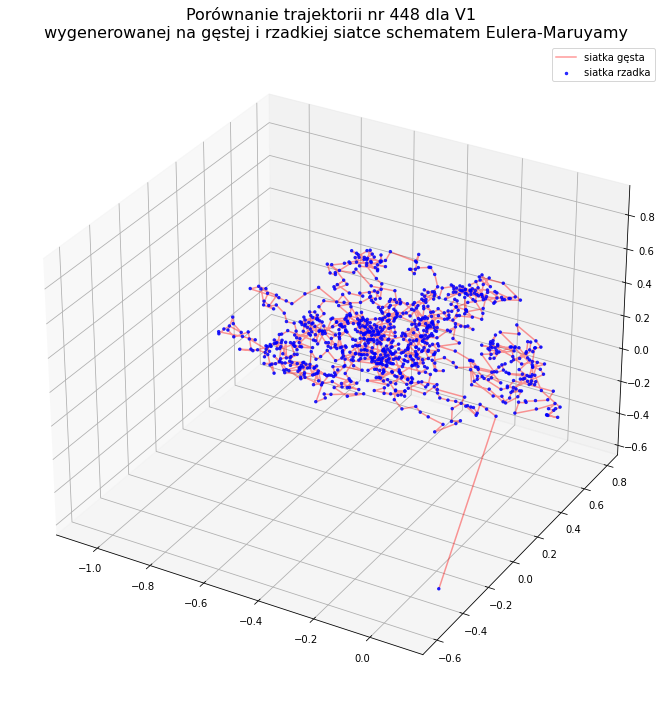

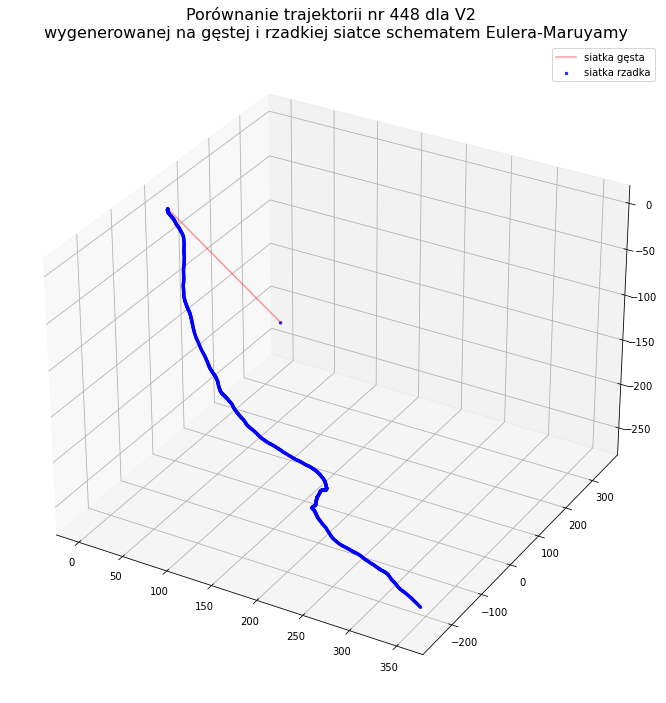

In [47]:
euler_wykres_V()

---
Model 2 - jednowymiarowy
---
$$dX_t = (\lambda X_t - X_t^2)dt + \sigma X_t dW_t$$


In [8]:
lam = 0.5
sigma = 1.0

@cuda.jit(device=True)
def a1(x):
  return lam * x - x**2

@cuda.jit(device=True)
def d_a1(x):
  return lam - 2 * x

@cuda.jit(device=True)
def d2_a1(x):
  return -2
  
@cuda.jit(device=True)
def b1(x):
  return sigma*x

@cuda.jit(device=True)
def d_b1(x):
  return sigma

@cuda.jit(device=True)
def d2_b1(x):
  return 0


In [9]:
#Schemat Eulera-Maruyamy - jednowymiarowy
@cuda.jit
def Euler_jednowymiarowy(states, N, n, T, x0, out_g, out_r):
  '''
  Funkcja generuje trajektorie przy użyciu schematu Eulera-Maruyamy i zapisuje do macierzy out_g - na siatce gęstej
  i do out_r - na siatce rzadkiej.

  Argumenty:
  states: stany wykorzystywane do generwania liczb pseudoloswych (cuda.random)
  N: int - liczba trajektorii
  n: int - gęstość siatki
  T: float - horyzont czasowy
  x0: float - początkowa wartość X
  out: matrix (n, N) - macierz, do której zapisywane są wyniki
  '''

  idx = cuda.grid(1)
  stride = cuda.gridsize(1)

  h_r = T/n
  h_g = T/(n*n)
  for i in range(idx, N, stride):
    Xt_r = x0
    Xt_g = x0
    out_g[0][i] = Xt_g
    out_r[0][i] = Xt_r
    
    for j_r in range(1, n+1):
      dW_r = 0.0
      for j_g in range(1, n+1):
        dW = cuda.random.xoroshiro128p_normal_float32(states, idx)
        dW_r +=dW
        Xt_g += a1(Xt_g) * h_g + b1(Xt_g) * dW * sqrt(h_g)
      out_g[j_r][i] = Xt_g
      Xt_r += a1(Xt_r) * h_r + b1(Xt_r) * dW_r * sqrt(h_r) /sqrt(float(n))
      out_r[j_r][i] = Xt_r
      

In [10]:
trajectories_num = 1000
grid_density = 1000
T = 1.0
X0 = 1.0

euler_1_g = cuda.device_array(shape=(grid_density, trajectories_num), dtype=np.float32)
euler_1_r = cuda.device_array(shape=(grid_density, trajectories_num), dtype=np.float32)

Euler_jednowymiarowy[blocks, threads_per_block](rng_states, trajectories_num, grid_density, T, X0, euler_1_g, euler_1_r)
euler_result_g = euler_1_g.copy_to_host()
euler_result_r = euler_1_r.copy_to_host()

In [11]:
def euler_wykres_1(nr=-1):
  if nr==-1:
    nr = int(np.random.uniform(low=0.0, high=trajectories_num))
  fig = plt.figure(figsize=(15,12))
  ax = fig.add_subplot()
  ax.set_title(f"Porównanie trajektorii nr {nr} dla Xt \n rozwiązania na siatce rzadkiej i gęstej", fontsize=16)
  t = np.linspace(0, T, grid_density)
  plt.plot(t, euler_result_r[:, nr], 'b.',alpha = 0.8, label = 'siatka rzadka')
  plt.plot(t, euler_result_g[:, nr], 'r', alpha = 0.5, label = 'siatka gęsta')
  ax.legend();
  

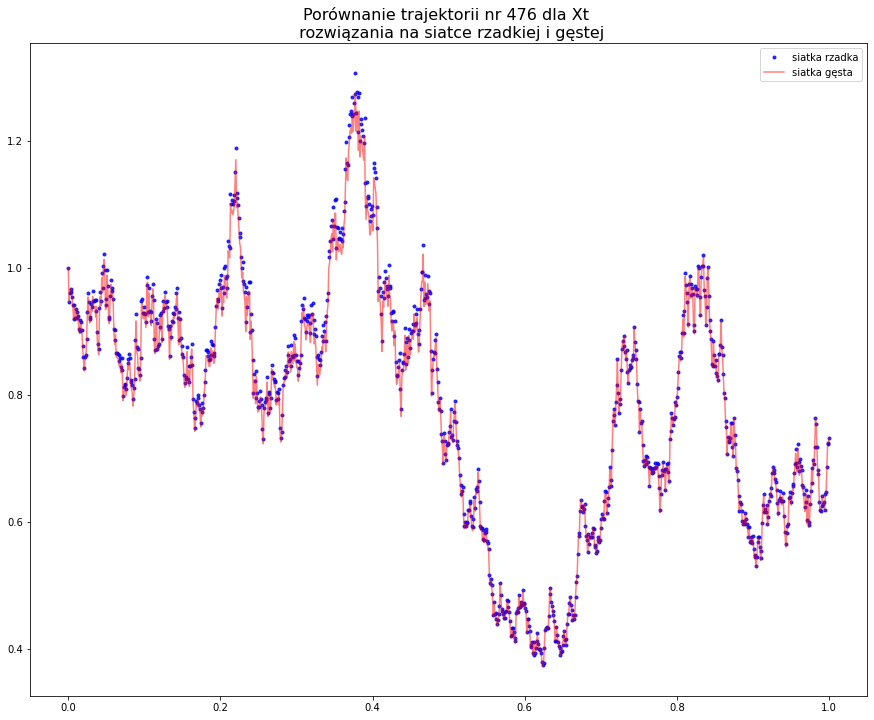

In [12]:
euler_wykres_1()

---
Schemat Wagnera-Platena
---

\begin{equation}
X_n^{WP} (t_0)  = X_{t_0} \\
X_n^{WP} (t_{i+1})  = X_n^{WP}(t_i) + a(X_n^{WP}(t_i))\frac{T}{n} + b(X_n^{WP}(t_i)) \Delta W_i + \\
+ L^0 a(X_n^{WP}(t_i)) J_{(0,0)}^{(t_i, t_{i+1})} + L^1 a(X_n^{WP}(t_i)) J_{(1,0)}^{(t_i, t_{i+1})} +\\
+ L^0 b(X_n^{WP}(t_i)) J_{(0,1)}^{(t_i, t_{i+1})} +L^1b(X_n^{WP}(t_i)) J_{(1,1)}^{(t_i, t_{i+1})},
\end{equation}

gdzie 
$$L^0 f(x) = a(x) \frac{d}{dx} f(x) + \frac12 b^2(x) \frac{d^2}{dx^2}f(x),$$

$$L^1 f(x) = b(x) \frac{d}{dx} f(x)$$
dla $f\in\{a, b\}.$

Oraz
\begin{equation}
\begin{split}
J_{(0,0)}^{(t_i, t_{i+1})} &= \int_{t_i}^{t_{i+1}} \int_{t_i}^s dzds = \frac12 \left(\frac{T}{n}\right)^2\\
J_{(0,1)}^{(t_i, t_{i+1})} &= \int_{t_i}^{t_{i+1}} \int_{t_i}^s dz dW_s = \frac{T}{n} W_{t_{i+1}} - \int_{t_i}^{t_{i+1}}W_s ds\\
J_{(1,0)}^{(t_i, t_{i+1})} &= \int_{t_i}^{t_{i+1}} \int_{t_i}^s dW_z ds = \int_{t_i}^{t_{i+1}} W_s ds - W_{t_i} \frac{T}{n}\\
J_{(1,1)}^{(t_i, t_{i+1})} &= \int_{t_i}^{t_{i+1}} \int_{t_i}^s dW_z dW_s = \frac12 \left((\Delta W_i)^2 - \frac{T}{n}\right)
\end{split}
\end{equation}

In [10]:
@cuda.jit
def Wagner_Platen(states, N_g, N_r, tr_num, T, x0, out_g, out_r):
  idx = cuda.grid(1)
  stride = cuda.gridsize(1)

  h_g = T/(N_g*N_r) #długość kroku na gęstej siatce
  h_r = T/N_r       #długość kroku na rzadkiej siatce
  sh_g = sqrt(h_g)  
  sh_r = sqrt(h_r)
  sN_g = sqrt(float(N_g))
  for i in range(idx, tr_num, stride):
    Xt_r = x0
    Xt_g = x0
    out_g[0][i] = Xt_g
    out_r[0][i] = Xt_r
    for j_r in range(1, N_r+1):
      ksi1_r = 0.0
      ksi2_r = 0.0

      for j_g in range(1, N_g+1):
        ksi1 = cuda.random.xoroshiro128p_normal_float32(states, idx)
        ksi2 = cuda.random.xoroshiro128p_normal_float32(states, idx)
        ksi1_r += ksi1
        ksi2_r += ksi2

        dW = ksi1 * sh_g
        dZ = 1/2 * (ksi1 + 1/sqrt(3.0) * ksi2) * (sh_g**3)

        J_00 = 1/2 * h_g**2
        J_10 = dZ
        J_01 = h_g * dW - J_10
        J_11 = 1/2 * (dW**2 - h_g)
        Xt_g += a1(Xt_g)*h_g + b1(Xt_g) * dW  + (a1(Xt_g) * d_a1(Xt_g) + 1/2 * (b1(Xt_g)**2) * d2_a1(Xt_g)) *J_00 + (b1(Xt_g)* d_a1(Xt_g)) * J_10 + (1/2 * b1(Xt_g)**2 * d2_b1(Xt_g)) * J_01 + b1(Xt_g)*d_b1(Xt_g) * J_11
      
      out_g[j_r, i] = Xt_g
      
      dW = ksi1_r * sh_r / sN_g
      dZ = 1/2 * (ksi1_r + 1/sqrt(3.0) * ksi2_r) * (sh_r**3) / sN_g

      J_00 = 1/2 * h_r**2
      J_10 = dZ
      J_01 = h_r * dW - J_10
      J_11 = 1/2 * (dW**2 - h_r)
      Xt_r += a1(Xt_r)*h_r + b1(Xt_r) * dW  + (a1(Xt_r) * d_a1(Xt_r) + 1/2 * (b1(Xt_r)**2) * d2_a1(Xt_r)) *J_00 + (b1(Xt_r)* d_a1(Xt_r)) * J_10 + (1/2 * b1(Xt_r)**2 * d2_b1(Xt_r)) * J_01 + b1(Xt_r)*d_b1(Xt_r) * J_11
      out_r[j_r, i] = Xt_r

In [14]:
trajectories_num = 10000
grid_density = 1000

T = 1.0
x0 = 1

WP_g = cuda.device_array(shape=(grid_density, trajectories_num), dtype=np.float32)
WP_r = cuda.device_array(shape=(grid_density, trajectories_num), dtype=np.float32)

Wagner_Platen[blocks, threads_per_block](rng_states, grid_density, grid_density, trajectories_num, T, x0,  WP_g, WP_r)

WP_result_g = WP_g.copy_to_host()
WP_result_r = WP_r.copy_to_host()

In [15]:
def WP_wykres(nr=-1):
  if nr==-1:
    nr = int(np.random.uniform(low=0.0, high=trajectories_num))
  fig = plt.figure(figsize=(15,12))
  ax = fig.add_subplot()
  ax.set_title(f"Porównanie trajektorii nr {nr} dla Xt \n rozwiązania na gęstej i rzadkiej siatce", fontsize=16)
  t = np.linspace(0, T, grid_density)
  plt.plot(t, WP_result_r[:, nr], 'b.', alpha =0.9,  label = 'siatka rzadka')
  plt.plot(t, WP_result_g[:, nr], 'r', alpha = 0.5, label = 'siatka gęsta')
  ax.legend();
  

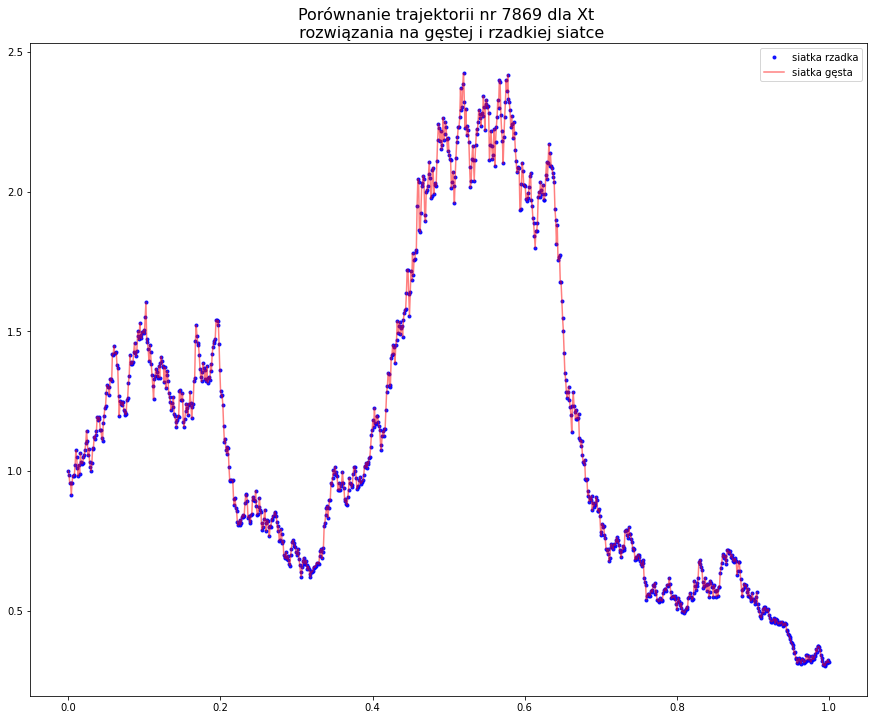

In [16]:
WP_wykres()

---
Połowienie kroku - oszacowanie błędu
---

In [9]:
#Schemat Eulera-Maruyamy - jednowymiarowy
@cuda.jit
def E(states, N, n_g, n_r, T, x0, out_g, out_r, err):
  '''
  Funkcja generuje trajektorie przy użyciu schematu Eulera-Maruyamy i zapisuje do macierzy out_g - na siatce gęstej
  i do out_r - na siatce rzadkiej.

  Argumenty:
  states: stany wykorzystywane do generwania liczb pseudoloswych (cuda.random)
  N: int - liczba trajektorii
  n: int - gęstość siatki
  T: float - horyzont czasowy
  x0: float - początkowa wartość X
  out: matrix (n, N) - macierz, do której zapisywane są wyniki
  '''

  idx = cuda.grid(1)
  stride = cuda.gridsize(1)

  h_r = T/n_r
  h_g = T/(n_r*n_g)
  for i in range(idx, N, stride):
    Xt_r = x0
    Xt_g = x0
    out_g[0][i] = Xt_g
    out_r[0][i] = Xt_r
    for j_r in range(1, n_r+1):
      dW_r = 0.0
      for j_g in range(1, n_g+1):
        dW = cuda.random.xoroshiro128p_normal_float32(states, idx)
        dW_r +=dW
        Xt_g += a1(Xt_g) * h_g + b1(Xt_g) * dW * sqrt(h_g)
      out_g[j_r][i] = Xt_g
      Xt_r += a1(Xt_r) * h_r + b1(Xt_r) * dW_r * sqrt(h_r) /sqrt(float(n_g))
      out_r[j_r][i] = Xt_r
    err[i] = abs(Xt_r -Xt_g)

In [9]:
@cuda.jit
def WP(states, N_g, N_r, tr_num, T, x0, out_g, out_r, err):
  idx = cuda.grid(1)
  stride = cuda.gridsize(1)

  h_g = T/(N_g*N_r) #długość kroku na gęstej siatce
  h_r = T/N_r       #długość kroku na rzadkiej siatce
  sh_g = sqrt(h_g)  
  sh_r = sqrt(h_r)
  sN_g = sqrt(float(N_g))
  for i in range(idx, tr_num, stride):
    err[i]=0.0
    Xt_r = x0
    Xt_g = x0
    out_g[0][i] = Xt_g
    out_r[0][i] = Xt_r
    for j_r in range(1, N_r+1):
      ksi1_r = 0.0
      ksi2_r = 0.0

      for j_g in range(1, N_g+1):
        ksi1 = cuda.random.xoroshiro128p_normal_float32(states, idx)
        ksi2 = cuda.random.xoroshiro128p_normal_float32(states, idx)
        ksi1_r += ksi1
        ksi2_r += ksi2

        dW = ksi1 * sh_g
        dZ = 1/2 * (ksi1 + 1/sqrt(3.0) * ksi2) * (sh_g**3)

        J_00 = 1/2 * h_g**2
        J_10 = dZ
        J_01 = h_g * dW - J_10
        J_11 = 1/2 * (dW**2 - h_g)
        Xt_g += a1(Xt_g)*h_g + b1(Xt_g) * dW  + (a1(Xt_g) * d_a1(Xt_g) + 1/2 * (b1(Xt_g)**2) * d2_a1(Xt_g)) *J_00 + (b1(Xt_g)* d_a1(Xt_g)) * J_10 + (1/2 * b1(Xt_g)**2 * d2_b1(Xt_g)) * J_01 + b1(Xt_g)*d_b1(Xt_g) * J_11
      
      out_g[j_r, i] = Xt_g
      
      dW = ksi1_r * sh_r / sN_g
      dZ = 1/2 * (ksi1_r + 1/sqrt(3.0) * ksi2_r) * (sh_r**3) / sN_g

      J_00 = 1/2 * h_r**2
      J_10 = dZ
      J_01 = h_r * dW - J_10
      J_11 = 1/2 * (dW**2 - h_r)
      Xt_r += a1(Xt_r)*h_r + b1(Xt_r) * dW  + (a1(Xt_r) * d_a1(Xt_r) + 1/2 * (b1(Xt_r)**2) * d2_a1(Xt_r)) *J_00 + (b1(Xt_r)* d_a1(Xt_r)) * J_10 + (1/2 * b1(Xt_r)**2 * d2_b1(Xt_r)) * J_01 + b1(Xt_r)*d_b1(Xt_r) * J_11
      out_r[j_r, i] = Xt_r
    err[i] = abs(Xt_r - Xt_g)

---
Euler-Maruyama

In [11]:
T = 10.0
x0 = 1.0

N = np.arange(9, 17)
trajectories_num = 1000
error = np.zeros(len(N))
E_g = cuda.to_device(np.zeros((2**N[-1], trajectories_num)).astype(np.float32))
E_r = cuda.to_device(np.zeros((2**N[-1], trajectories_num)).astype(np.float32))
err = cuda.device_array(shape=(trajectories_num,), dtype = np.float32)
                        
for i , n in enumerate(N):
    grid_density = 2**n
    E[blocks, threads_per_block](rng_states, trajectories_num,1000, grid_density, T, x0,  E_g, E_r, err)
    err_res = err.copy_to_host()
    error[i] = np.mean(err_res)
    
err2 = error[:-1]/error[1:]
n = 2**N

In [12]:
table = list()
for i in range(len(n)-1):
    table.append([f'{n[i+1]}/{n[i]}', np.log2(err2[i])])
print(tabulate(table, headers=['N[i+1]/N[i]','log2(err[i+1]/err[i])'], tablefmt='orgtbl'))

| N[i+1]/N[i]   |   log2(err[i+1]/err[i]) |
|---------------+-------------------------|
| 1024/512      |                0.619296 |
| 2048/1024     |                0.584908 |
| 4096/2048     |                0.525685 |
| 8192/4096     |                0.391605 |
| 16384/8192    |                0.505008 |
| 32768/16384   |                0.566169 |
| 65536/32768   |                0.540681 |


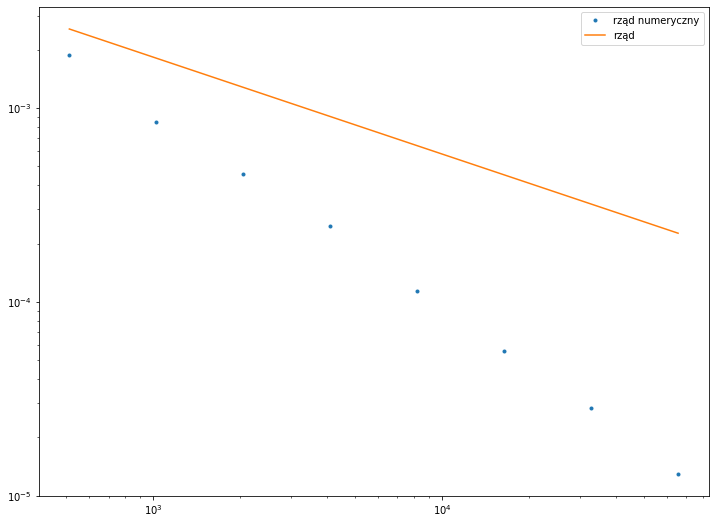

In [20]:
nachylenie = 1/2
fig, ax = plt.subplots(figsize=(12, 9))
ax.loglog(n, error, '.', label='rząd numeryczny')
ax.loglog([n[0], n[-1]], [n[-1]**nachylenie*10**(-5), n[0]**nachylenie*10**(-5)], label='rząd')
plt.legend();

---
Wagner-Platen

In [10]:
T = 10.0
x0 = 1.0

N = np.arange(9, 17)
trajectories_num = 1000
error = np.zeros(len(N))
WP_g = cuda.to_device(np.zeros((2**N[-1], trajectories_num)).astype(np.float32))
WP_r = cuda.to_device(np.zeros((2**N[-1], trajectories_num)).astype(np.float32))
err = cuda.device_array(shape=(trajectories_num,), dtype = np.float32)
for i , n in enumerate(N):
    grid_density = 2**n
    WP[blocks, threads_per_block](rng_states, 1000, grid_density, trajectories_num, T, x0,  WP_g, WP_r, err)
    err_res = err.copy_to_host()
    error[i] = np.mean(err_res)
err2 = error[:-1]/error[1:]
n = 2**N

In [11]:
table = list()
for i in range(len(n)-1):
    table.append([f'{n[i+1]}/{n[i]}', np.log2(err2[i])])
print(tabulate(table, headers=['N[i+1]/N[i]','log2(err[i+1]/err[i])'], tablefmt='orgtbl'))

| N[i+1]/N[i]   |   log2(err[i+1]/err[i]) |
|---------------+-------------------------|
| 1024/512      |                1.14128  |
| 2048/1024     |                0.899501 |
| 4096/2048     |                0.895381 |
| 8192/4096     |                1.11758  |
| 16384/8192    |                1.02681  |
| 32768/16384   |                0.9752   |
| 65536/32768   |                1.12297  |


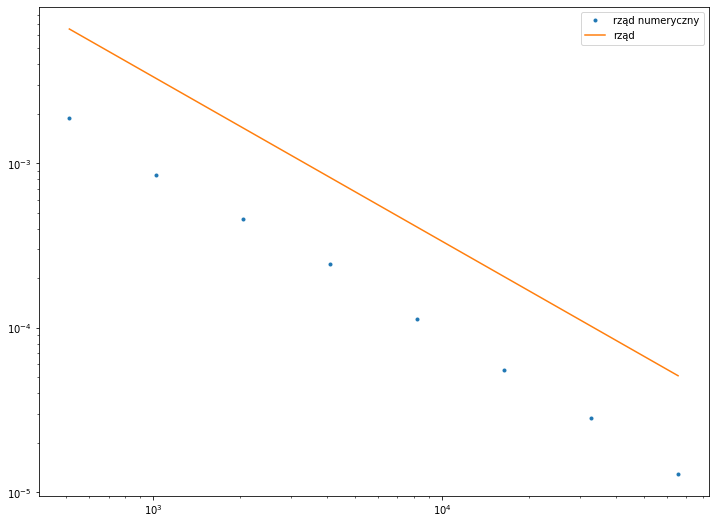

In [24]:
nachylenie = 1
fig, ax = plt.subplots(figsize=(12, 9))
ax.loglog(n, error, '.', label='rząd numeryczny')
ax.loglog([n[0], n[-1]], [n[-1]**nachylenie*10**(-7), n[0]**nachylenie*10**(-7)], label='rząd')
plt.legend();

---
Bibliografia
---
P. E. Kloeden, E. Platen, Numerical  Solution  of  Stochastic  Differential  Equations,Springer, 1999